In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import pickle

# ***Mounting the Drive***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text)  # remove HTML
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove links
    text = re.sub(r"[^a-zA-Z\s]", '', text)  # remove punctuation/numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Class/IMDB Dataset.csv')[:34000]
df['review'] = df['review'].astype(str).apply(clean_text)

In [5]:
print(df)

                                                  review sentiment
0      one of the other reviewers has mentioned that ...  positive
1      a wonderful little production the filming tech...  positive
2      i thought this was a wonderful way to spend ti...  positive
3      basically theres a family where a little boy j...  negative
4      petter matteis love in the time of money is a ...  positive
...                                                  ...       ...
33995  idiots go camping and act like idiots before t...  negative
33996  aparna sens  park avenue is a film about natur...  positive
33997  the preposterous premise of this flick has to ...  negative
33998  manna from heaven is heavenly this is a movie ...  positive
33999  ugh this is a terrible film full of disastrous...  negative

[34000 rows x 2 columns]


In [6]:
# Preprocess text
texts = df['review'].astype(str).values
labels = df['sentiment'].values

In [7]:
# Label encoding
le = LabelEncoder()
labels = le.fit_transform(labels)

In [14]:
# Tokenize
vacab_size = 10000
max_len = 1000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vacab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences,padding='pre', maxlen = max_len, truncating='post')

In [15]:
padded

array([[   0,    0,    0, ...,  122, 4269,  497],
       [   0,    0,    0, ..., 1867,   72,  222],
       [   0,    0,    0, ...,   64,   15,  326],
       ...,
       [   0,    0,    0, ...,    5,    1,    1],
       [   0,    0,    0, ...,    4,    1, 2668],
       [   0,    0,    0, ..., 2486,   55,  247]], dtype=int32)

In [16]:
# Train/ test split
x_train,x_test,y_train,y_test = train_test_split(padded,labels,test_size=0.2,random_state=42)

In [17]:
# Model
model = Sequential([
    Embedding(input_dim=vacab_size,output_dim=64,input_length=max_len),
    GRU(64,return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [18]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [19]:
model.fit(x_train, y_train, epochs=4, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/4
850/850 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.6832 - loss: 0.5692 - val_accuracy: 0.8538 - val_loss: 0.3531
Epoch 2/4
850/850 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.8922 - loss: 0.2825 - val_accuracy: 0.8794 - val_loss: 0.2963
Epoch 3/4
850/850 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.9274 - loss: 0.2028 - val_accuracy: 0.8854 - val_loss: 0.3054
Epoch 4/4
850/850 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9557 - loss: 0.1296 - val_accuracy: 0.8871 - val_loss: 0.2926


213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.88      0.88      3367
    positive       0.88      0.90      0.89      3433

    accuracy                           0.89      6800
   macro avg       0.89      0.89      0.89      6800
weighted avg       0.89      0.89      0.89      6800



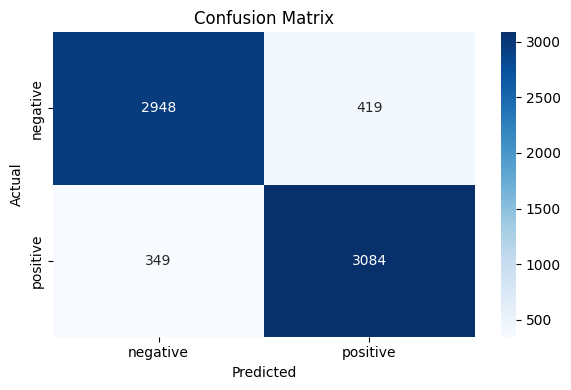

In [20]:

# Evaluate the Model

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=le.classes_)

print("\nClassification Report:\n", cr)

#  Plot Confusion Matrix

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# -----------------------#

In [21]:
# Save
model.save("sentiment_model.keras")

In [22]:
from google.colab import files
files.download("sentiment_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
files.download("tokenizer.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>